# **Modelos Benchmarks**

In [2]:
# Librerias Importadas

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera



Se importa la base de datos y definimos las variables predictoras y la variable respuesta. Luego, dividimos los datos para formar el conjunto de entrenamiento y el de prueba.

In [7]:
# Cargar datos
df = pd.read_csv(r"C:\Users\TAWTOCA\OneDrive - Universidad del Norte\Documentos\Visual Files\Rentabilidad_filtrado.csv")

# Definir variables predictoras y respuesta
X = df[["APORTES_RECIBIDOS", "PRECIERRE_FONDO_DIA_T", "TIPO_PARTICIPACION", "NUMERO_INVERSIONISTAS", "TIPO_ENTIDAD"]]
y = df["RETIROS_REDENCIONES"]



# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Funciones**

Creamos funciones clave para optimizar la creación de graficos y el calculo de metricas para los respectivos modelos de regresión.

In [5]:
def analizar_residuos(residuos, ljung_box_p_value):
    """
    Aplica transformaciones a los residuos y genera gráficos.
    
    Parámetros:
    - residuos: array-like, residuos del modelo.
    - ljung_box_p_value: float, p-valor de la prueba de Ljung-Box.
    """
    # Aplicar transformaciones
    residuos_esc = (residuos - np.mean(residuos)) / np.std(residuos)  # Escalar residuos
    residuos_log = np.log1p(np.abs(residuos)) * np.sign(residuos)  # Log-transformación
    
    # Crear figura con dos subgráficos
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 📊 Gráfico 1: ACF de los residuos escalados
    plot_acf(residuos_esc, ax=axes[0], lags=30)
    axes[0].set_title(f"ACF de los Residuos Escalados\nLjung-Box: {ljung_box_p_value:.4f}")
    
    # 📊 Gráfico 2: Histograma de los residuos log-transformados
    sns.histplot(residuos_log, bins=30, kde=True, ax=axes[1])
    axes[1].set_title("Histograma de los Residuos Log-transformados")
    axes[1].set_xlabel("Valor del Residuo Transformado")
    
    # Ajustar diseño y mostrar gráficos
    plt.tight_layout()
    plt.show()

In [6]:
def scatter_real_vs_pred(y_test, y_test_pred):
    """
    Crea un gráfico de dispersión comparando los valores reales vs los predichos.
    
    Parámetros:
    - y_test: array-like, valores reales.
    - y_test_pred: array-like, valores predichos.
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5)
    
    # Agregar línea de referencia y etiquetas
    plt.axline((0, 0), slope=1, color="red", linestyle="--", label="Línea Ideal (y=x)")
    plt.xlabel("Valor Real")
    plt.ylabel("Valor Predicho")
    plt.title("Dispersión: Real vs Predicho")
    plt.legend()
    
    # Mostrar gráfico
    plt.show()

In [7]:
def calcular_metricas(y_test, y_test_pred):
    """
    Calcula métricas de error y realiza pruebas estadísticas sobre los residuos.
    
    Parámetros:
    - y_test: array-like, valores reales.
    - y_test_pred: array-like, valores predichos.
    
    Retorna:
    - DataFrame con métricas MAPE, RMSE, R², Ljung-Box p-value y Jarque-Bera p-value.
    - Residuos calculados.
    """
    # Calcular métricas
    mae = mean_absolute_percentage_error(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)
    
    # Residuos
    residuos = y_test - y_test_pred
    
    # Pruebas estadísticas
    ljung_box_p_value = acorr_ljungbox(residuos, lags=[10]).iloc[0, 1]
    jarque_bera_p_value = jarque_bera(residuos)[1]
    
    # Crear DataFrame con resultados
    resultados = pd.DataFrame({
        "MAPE": [mae],
        "RMSE": [rmse],
        "R²": [r2],
        "Ljung-Box p-value": [ljung_box_p_value],
        "Jarque-Bera p-value": [jarque_bera_p_value]
    })
    
    return resultados, residuos, ljung_box_p_value

## **Regresión Lineal**

In [8]:

st = time.time()
lr = LinearRegression().fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))

print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

Tiempo de entrenamiento: 0.07 segundos
Training set score: 0.72
Test set score: 0.70


La diferencia entre entrenamiento y prueba es pequeña, lo que sugiere que el modelo no está sobreajustando. Aunque el rendimiento se puede mejorar.

In [9]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [10]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  3.372330e+09  2.425426e+10  0.695488           0.709286   

   Jarque-Bera p-value  
0                  0.0  


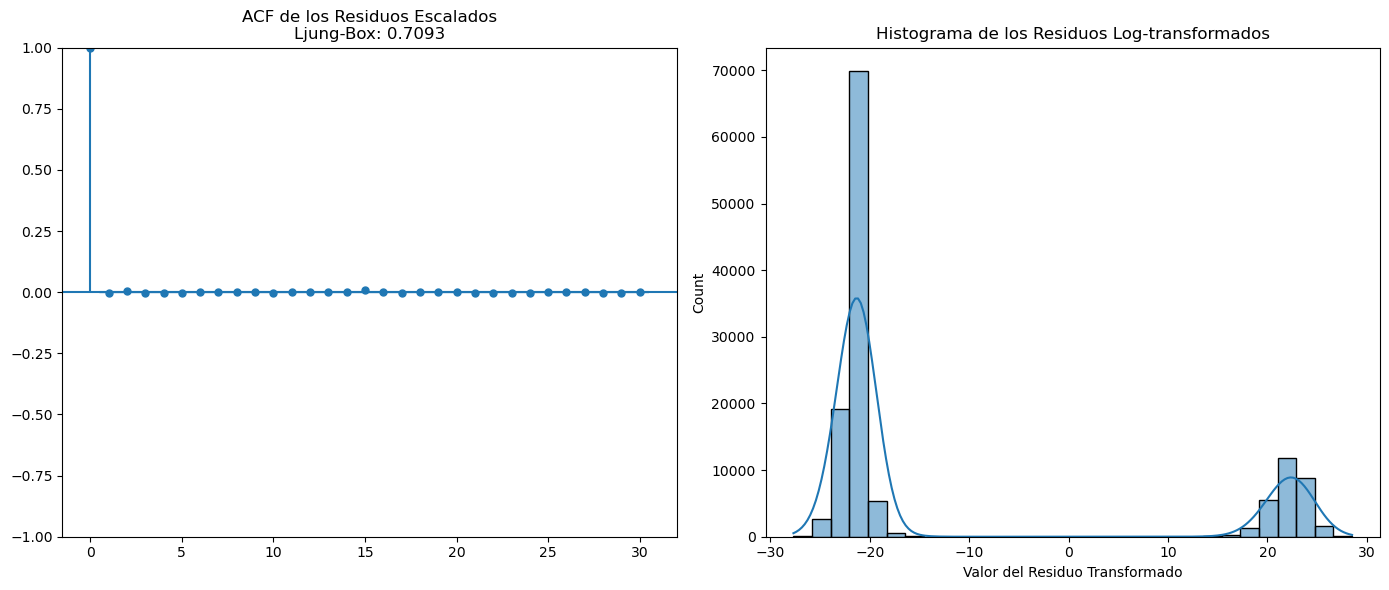

In [11]:
analizar_residuos(residuos, ljung_box_p_value)

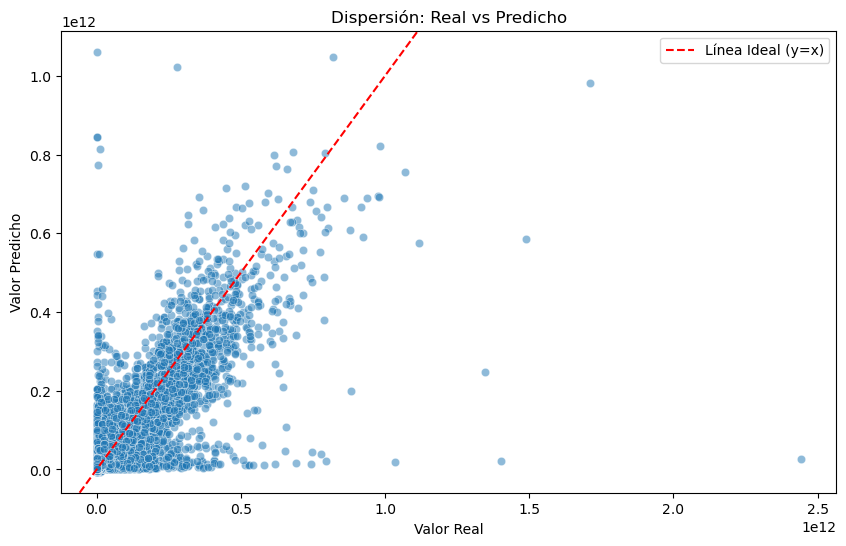

In [12]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Regresión de Ridge**

In [13]:
st = time.time()
ridge = Ridge().fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Tiempo de entrenamiento: 0.04 segundos
Training set score: 0.72
Test set score: 0.70


Mismos resultados que la regresión lineal. Dado que es una variante de la regresión lineal que incorpora regularización L2 para reducir el sobreajuste, podemos decir que el modelo de regresión lineal esta bien generalizado. 

In [14]:
y_test_pred = ridge.predict(X_test)

resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)


           MAPE          RMSE        R²  Ljung-Box p-value  \
0  3.372361e+09  2.425426e+10  0.695488           0.709285   

   Jarque-Bera p-value  
0                  0.0  


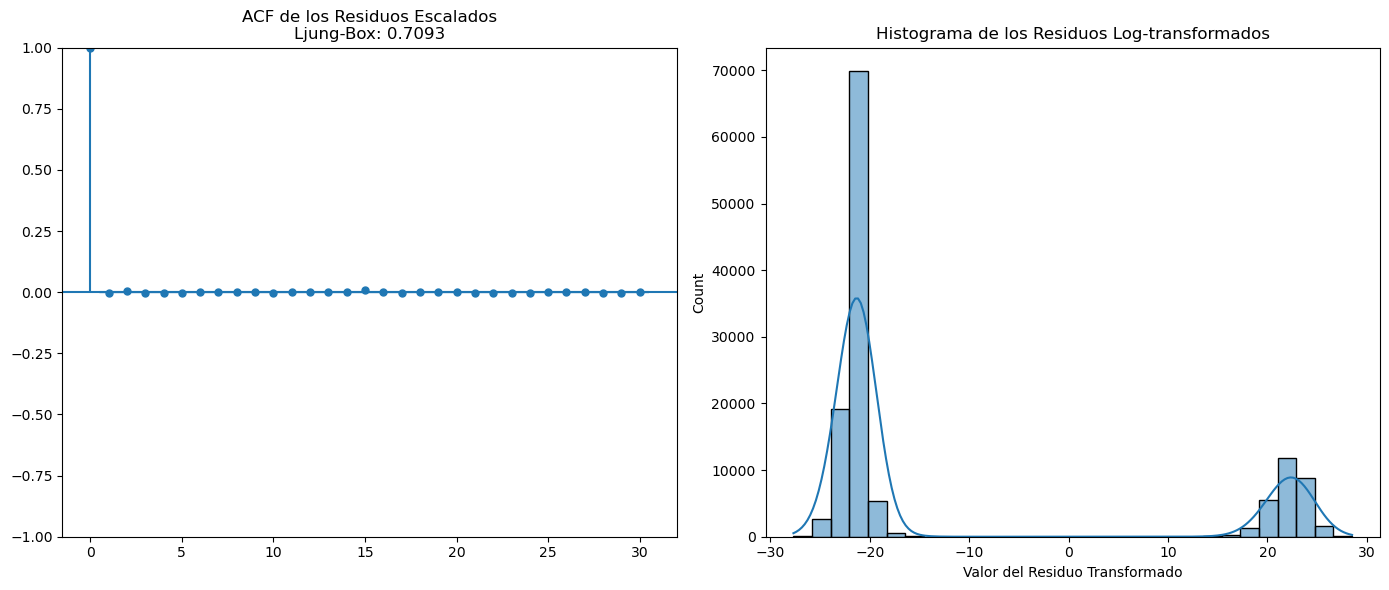

In [15]:
analizar_residuos(residuos, ljung_box_p_value)

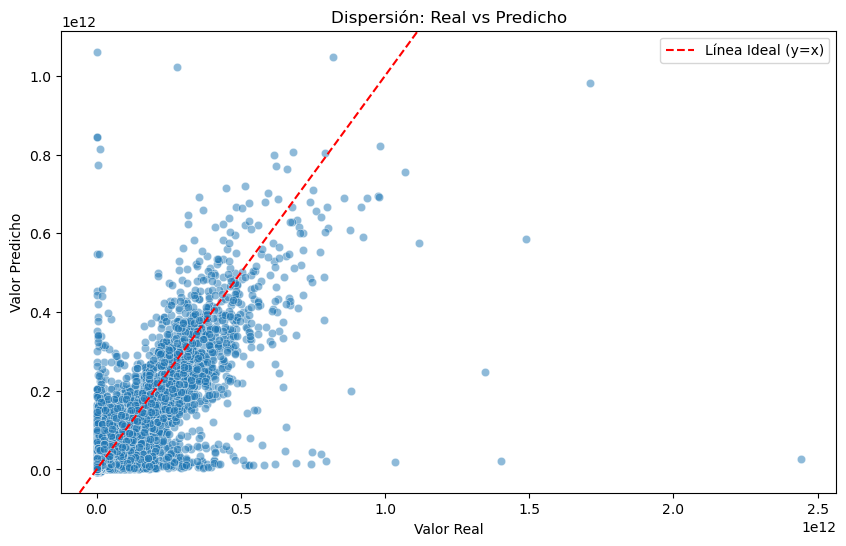

In [16]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Regresión de Lasso**

In [17]:
st = time.time()
lasso = Lasso().fit(X_train, y_train)
et = time.time()    
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Tiempo de entrenamiento: 0.46 segundos
Training set score: 0.72
Test set score: 0.70
Number of features used: 4


Lasso es similar a Ridge pero utiliza una penalización L1, lo que permite la selección automática de características al forzar coeficientes irrelevantes a cero. Dado que Ridge no tuvo mucha variación con respecto a la regresión lineal, Lasso tampoco haría mucha diferencia. 

In [18]:

y_test_pred = lasso.predict(X_test)

In [19]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  3.372330e+09  2.425426e+10  0.695488           0.709286   

   Jarque-Bera p-value  
0                  0.0  


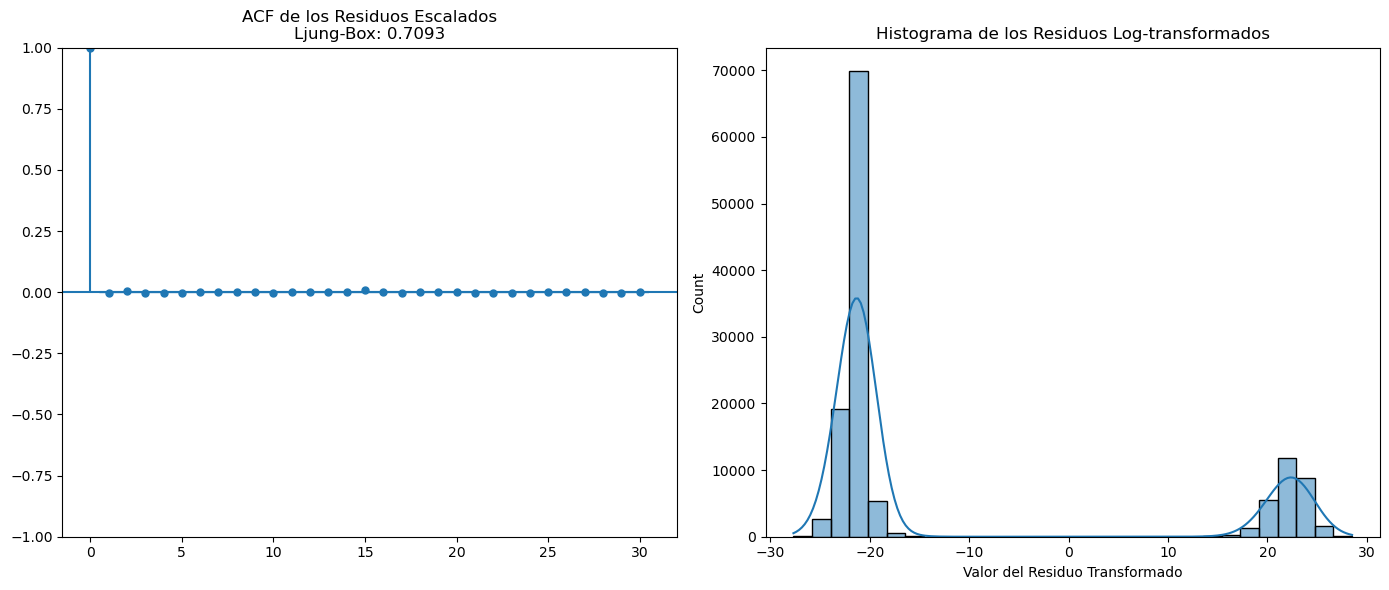

In [20]:
analizar_residuos(residuos, ljung_box_p_value)

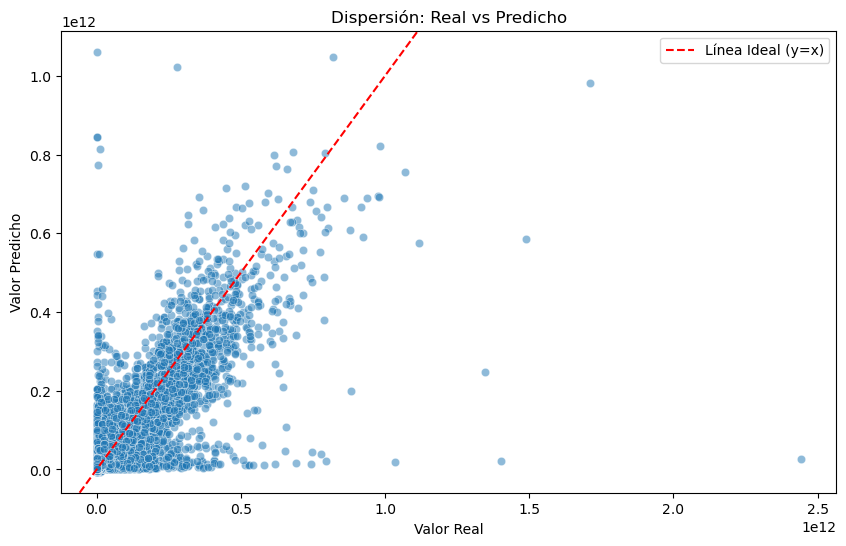

In [21]:
scatter_real_vs_pred(y_test, y_test_pred)

## **KNN**

In [8]:
KNN = KNeighborsRegressor(n_neighbors=5, weights='uniform')
st = time.time()    
    # Entrenar el modelo
KNN.fit(X_train, y_train)
et = time.time()

print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
    # Predicciones
y_train_pred = KNN.predict(X_train)
y_test_pred = KNN.predict(X_test)
    
print("Training set score: {:.2f}".format(KNN.score(X_train, y_train)))
print("Test set score: {:.2f}".format(KNN.score(X_test, y_test)))

Tiempo de entrenamiento: 1.02 segundos
Training set score: 0.78
Test set score: 0.74


KNN no asume una relación lineal y, en este caso, logra un mejor rendimiento en prueba (0.74).

In [23]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  5.887650e+08  2.316802e+10  0.722153           0.454473   

   Jarque-Bera p-value  
0                  0.0  


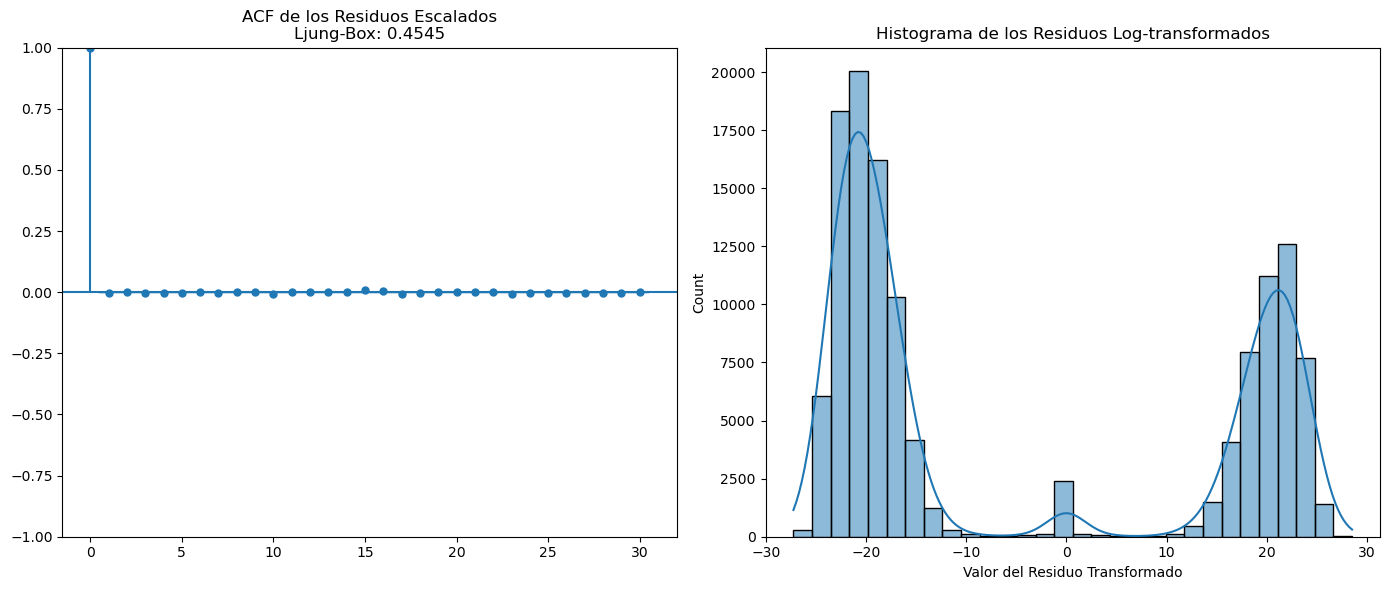

In [24]:
analizar_residuos(residuos, ljung_box_p_value)

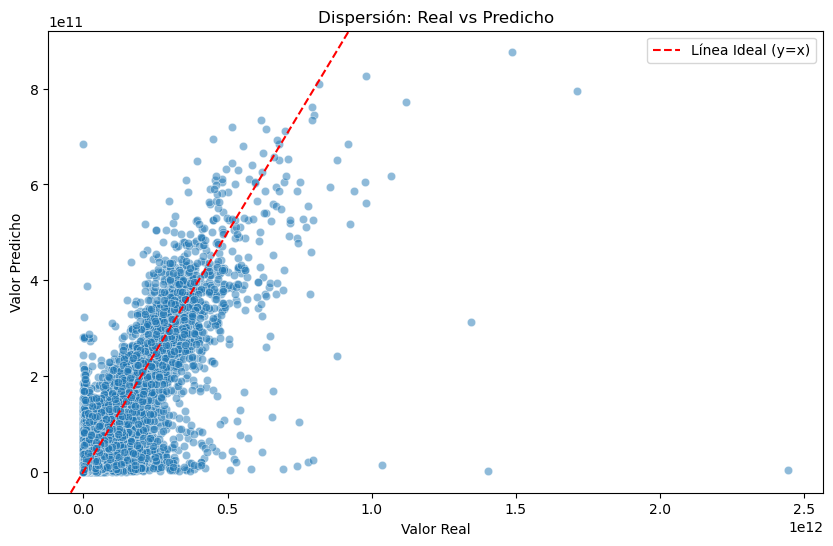

In [25]:
scatter_real_vs_pred(y_test, y_test_pred)

## **Random Forest**

In [26]:
RANFOR = RandomForestRegressor(n_estimators=300, max_depth=6, max_features='sqrt', random_state=42)
st = time.time()
RANFOR.fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))

# Predicciones
y_train_pred = RANFOR.predict(X_train)
y_test_pred = RANFOR.predict(X_test)

    # Imprimir R²
print("Training set score: {:.2f}".format(RANFOR.score(X_train, y_train)))
print("Test set score: {:.2f}".format(RANFOR.score(X_test, y_test)))

Tiempo de entrenamiento: 233.17 segundos
Training set score: 0.77
Test set score: 0.75


Random Forest logra el mejor rendimiento en prueba (0.75). Sin embargo, su alto tiempo de entrenamiento lo convierte en una opción computacionalmente costosa. 

In [27]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE       R²  Ljung-Box p-value  Jarque-Bera p-value
0  2.670355e+09  2.217457e+10  0.74547           0.225338                  0.0


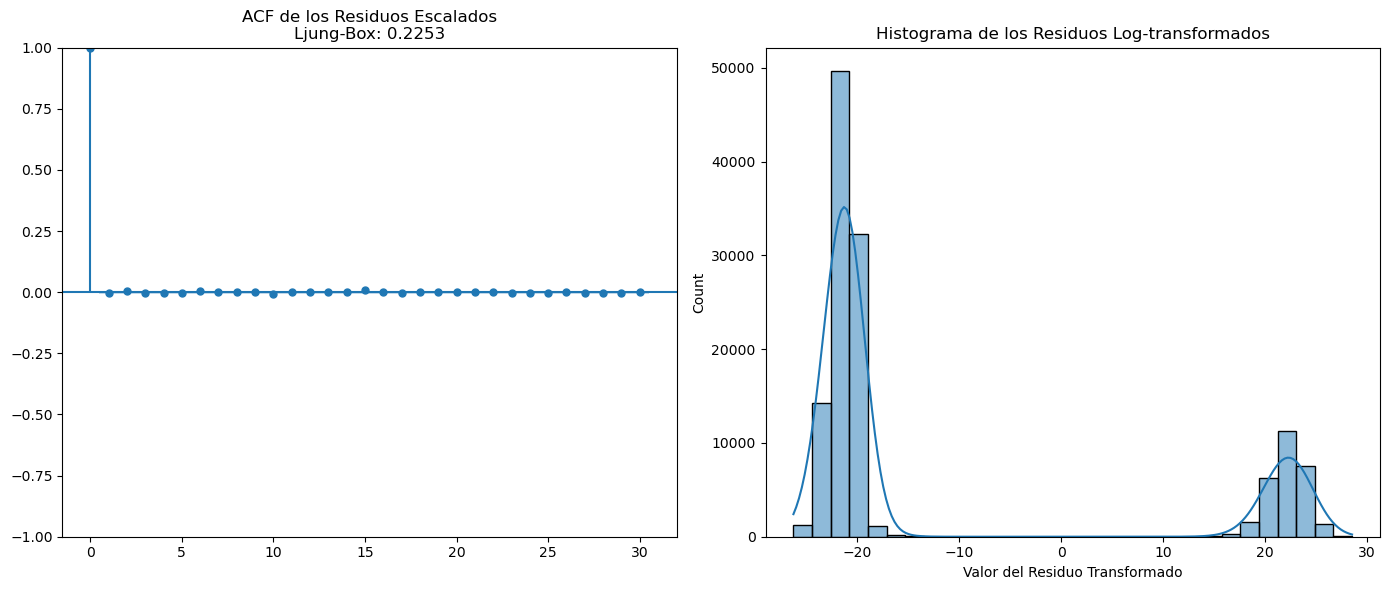

In [28]:
analizar_residuos(residuos, ljung_box_p_value)

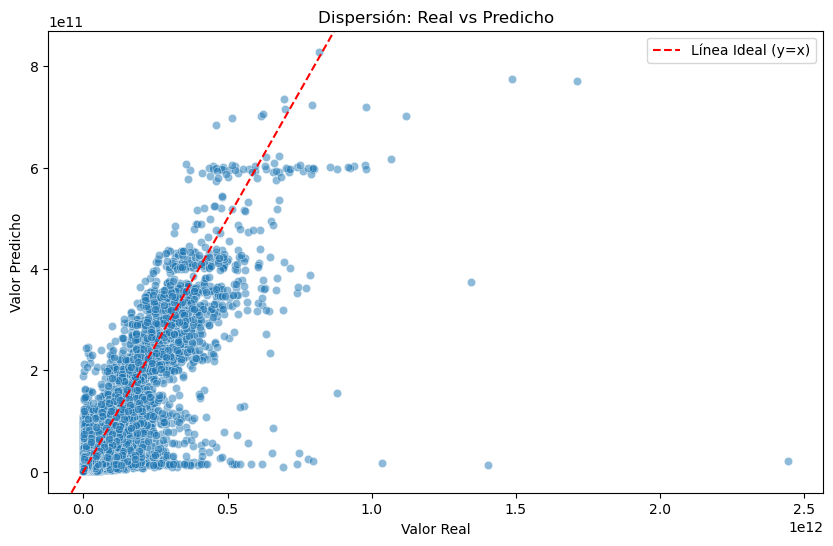

In [29]:
scatter_real_vs_pred(y_test, y_test_pred)

## **XGBoost**

In [30]:
XGB = XGBRegressor(
    n_estimators=500,        # Aumentar número de árboles
    learning_rate=0.05,      # Reducir tasa de aprendizaje
    max_depth=4,             # Menos profundidad para evitar sobreajuste
    min_child_weight=5,      # Aumentar para evitar divisiones innecesarias
    subsample=0.8,           # Muestra aleatoria del 80% de los datos en cada árbol
    colsample_bytree=0.8,    # Selección aleatoria del 80% de las características
    reg_alpha=0.1,           # Regularización L1 (Lasso)
    reg_lambda=1,            # Regularización L2 (Ridge)
    random_state=42,
    n_jobs=-1       # Métrica de evaluación
)

st = time.time()
    # Entrenar el modelo
XGB.fit(X_train, y_train)
et = time.time()
print("Tiempo de entrenamiento: {:.2f} segundos".format(et - st))
    
    # Predicciones
y_train_pred = XGB.predict(X_train)
y_test_pred = XGB.predict(X_test)
    
print("Training set score: {:.2f}".format(XGB.score(X_train, y_train)))
print("Test set score: {:.2f}".format(XGB.score(X_test, y_test)))

Tiempo de entrenamiento: 11.74 segundos
Training set score: 0.76
Test set score: 0.71


Aunque su rendimiento en prueba (0.72) es un poco menor que el de Random Forest, su tiempo de entrenamiento es significativamente menor (10.73s vs. 162.86s).

In [31]:
resultados, residuos, ljung_box_p_value = calcular_metricas(y_test, y_test_pred)
print(resultados)

           MAPE          RMSE        R²  Ljung-Box p-value  \
0  1.194921e+09  2.375368e+10  0.707928           0.734061   

   Jarque-Bera p-value  
0                  0.0  


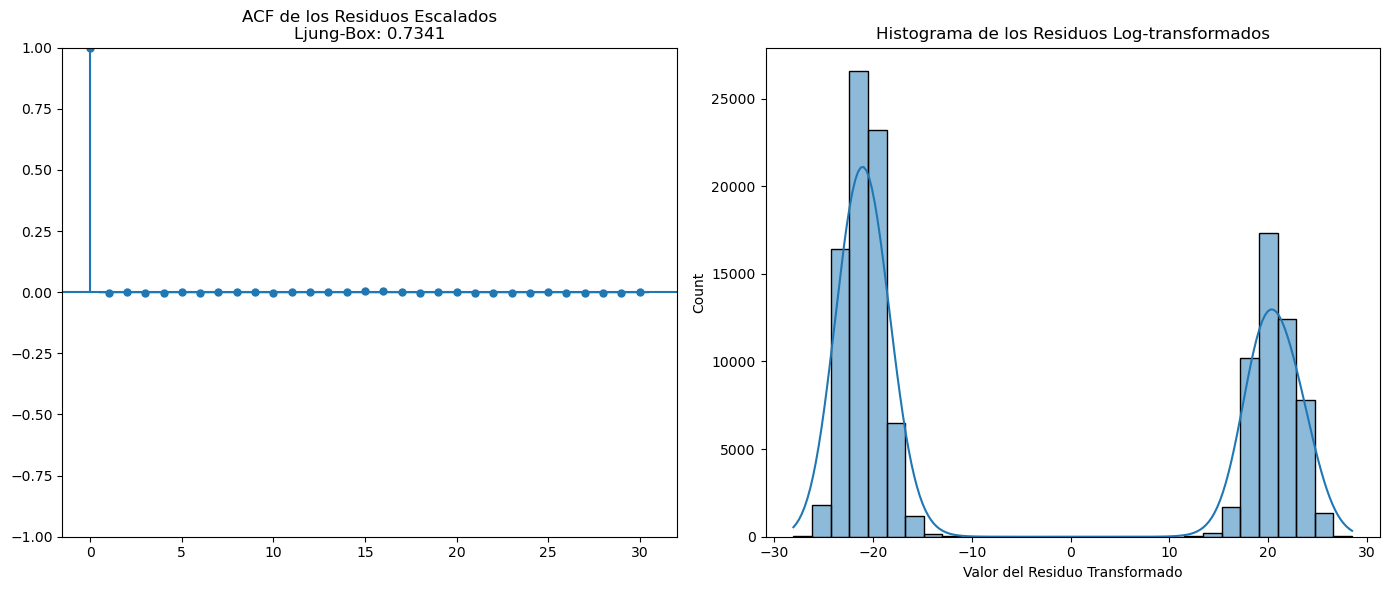

In [32]:
analizar_residuos(residuos, ljung_box_p_value)

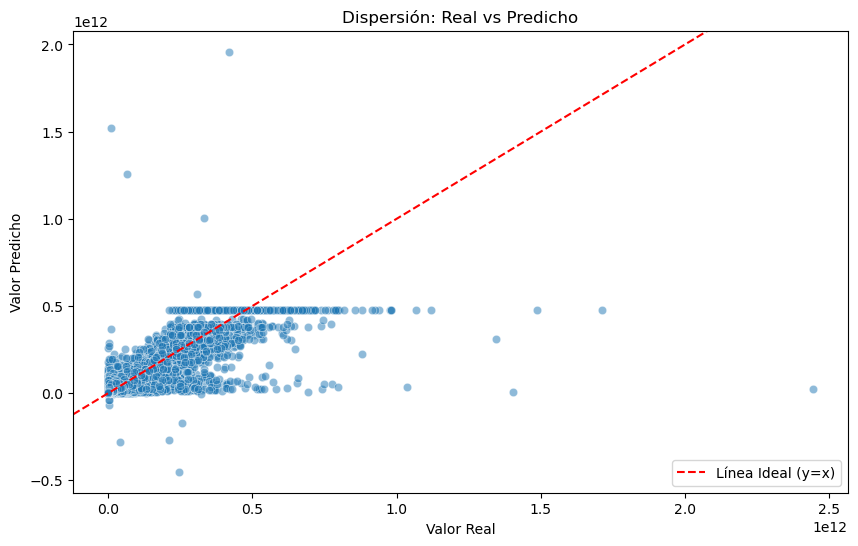

In [33]:
scatter_real_vs_pred(y_test, y_test_pred)